# **Desafío Spike - Predicción de desviación de precios en el sistema eléctrico chileno**

Primero importar las librerías y herramientas necesarias

In [ ]:
import pandas as pd # data manipulation

import numpy as np # data manipulation
import matplotlib.pyplot as plt # visualization
import math # general math
import xgboost as xgb # ML Technique here used
from xgboost import plot_importance, plot_tree # Model interpretation
from sklearn.metrics import confusion_matrix # Tools for ML
from sklearn.metrics import mean_squared_error, mean_absolute_error # Tools for ML
# for showing dinamic tables 
%load_ext google.colab.data_table # make tables beautiful


# **1. Costos marginales**


**1.1 Cargar el archivo y hacer un merge del costo marginal real con el costo marginal programado**



In [ ]:
# A) Upload data

# invoke a file selector (select the files)
from google.colab import files

uploaded = files.upload()

# iterate the uploaded files in order to find their key names
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving costo_marginal_real.csv to costo_marginal_real.csv
User uploaded file "costo_marginal_real.csv" with length 390673661 bytes


In [ ]:
costo_real = pd.read_csv('costo_marginal_real.csv')
costo_real.head()

,barra_mnemotecnico,barra_referencia_mnemotecnico,fecha,hora,costo_en_dolares,costo_en_pesos,nombre
0,BA01T005SE075T005,BA02T002SE032T002,2019-04-06,25,62.24,41.47176,BA S/E LORETO 15KV
1,BA01T005SE175T005,BA02T002SE032T002,2019-04-06,25,62.56,41.68498,BA S/E RETIRO 13.2KV
2,BA03R002SE002R002,BA02T002SE032T002,2019-04-06,25,60.04,40.00585,BA S/E ALTAMIRANO 12.5KV BP1
3,BA01R002SE012R002,BA02T002SE032T002,2019-04-06,25,61.65,41.07863,BA S/E CURACAVI 44KV B1
4,BA03R002SE013R002,BA02T002SE032T002,2019-04-06,25,59.55,39.67936,BA S/E EL MANZANO (ENEL DISTRIBUCIÓN) 23KV BP1


In [ ]:
costo_programado = pd.read_csv('costo_marginal_programado.csv')
costo_programado.head()

,mnemotecnico_barra,nombre_barra,fecha,hora,costo
0,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,1.0,49.897334
1,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,2.0,50.471616
2,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,3.0,50.077821
3,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,4.0,49.796216
4,BA01T002SE002T002,BA S/E ALTO JAHUEL 110KV SECCION 1,2019-01-01,5.0,49.796216


In [ ]:
# B) Merge costos reales and costos programados

# change 'fecha' data type to to_datetime data type
costo_real['fecha'] = pd.to_datetime(costo_real['fecha']) 
costo_programado['fecha'] = pd.to_datetime(costo_programado['fecha']) # change 'fecha' data type to to_datetime data type

# rename columns to later make the merge
costo_programado.rename(columns={'mnemotecnico_barra':'barra_mnemotecnico','nombre_barra':'nombre'}, inplace=True)

# merge
costo_marginal = pd.merge(costo_real,costo_programado,on=['barra_mnemotecnico','nombre','fecha','hora'])
costo_marginal = costo_marginal.drop(['costo_en_pesos'],1) # drop redundant variable

# rename with appropriate variable names
costo_marginal.rename(columns={'costo_en_dolares':'costo_real','costo':'costo_programado'}, inplace=True)
costo_marginal.head()

,barra_mnemotecnico,barra_referencia_mnemotecnico,fecha,hora,costo_real,nombre,costo_programado
0,BA01G021SE018G021,BA02T002SE032T002,2019-04-06,25,58.02,BA S/E CENTRAL QUINTERO 220KV,54.292145
1,BA01T018SE001T018,BA02T002SE032T002,2019-04-06,25,63.60,BA S/E NUEVA PICHIRROPULLI 220KV B1,60.620648
2,BA02T005SE055T005,BA02T002SE032T002,2019-04-06,25,62.78,BA S/E SAN FRANCISCO DE MOSTAZAL 66KV T1,59.177969
3,BA01T002SE029T002,BA02T002SE032T002,2019-04-06,25,58.55,BA S/E CENTRAL PEHUENCHE 220KV B1,54.566605
4,BA01R002SE041R002,BA02T002SE032T002,2019-04-06,25,60.39,BA S/E SAN CRISTOBAL 110KV B1,56.086260


**1.2. Análisis exploratorio**

In [ ]:
# A) check for duplicated data
duplicated = costo_marginal[costo_marginal.duplicated(subset=['barra_mnemotecnico','nombre','fecha','hora'], keep=False)] # create a df only with the duplicates
# percentage of duplicated data
percentage_duplicated = round(100 * ((len(duplicated.index))/2) / len(costo_marginal.index),2)
print(percentage_duplicated,'% of the data are duplicates')

1.36 % of the data are duplicates


**Observaciones:**
- Hay costos programados que se calcularon dos veces (duplicados)
- El total de los datos duplicados es de tan solo 1.36%

In [ ]:
# Analyse duplicated data

duplicates_analysis = duplicated.drop(['Unnamed: 0'],1) # an unnesessary column was created, so, drop it
# Put duplicates in a column so that it can be compared
duplicates_analysis = duplicated.join(duplicates_analysis.groupby(['barra_mnemotecnico','nombre','fecha','hora']).last(), on=['barra_mnemotecnico','nombre','fecha','hora'], rsuffix='_dup').drop_duplicates(subset=['costo_real_dup','costo_programado_dup']).reset_index(drop=True)
# Calculate the diference between the duplicates 
duplicates_analysis['diferencia'] = np.sqrt((duplicates_analysis['costo_programado_dup'] - duplicates_analysis['costo_programado'])**2)
# Descriptive statistics
pd.DataFrame(duplicates_analysis.describe())

,Unnamed: 0,hora,costo_real,costo_programado,costo_real_dup,costo_programado_dup,diferencia
count,11196.000000,11196.000000,11196.000000,11196.000000,11196.000000,11196.000000,11196.000000
mean,451685.339764,12.378885,58.702625,63.288087,58.702625,60.176022,5.337200
std,267796.170102,7.035156,19.198866,21.185271,19.198866,18.894872,7.040727
min,98.000000,1.000000,0.000000,0.041758,0.000000,0.042030,0.000272
25%,222928.750000,6.000000,48.860000,51.291060,48.860000,50.054285,2.279788
50%,440613.500000,12.000000,53.220000,57.353174,53.220000,54.481974,3.244490
75%,692079.000000,19.000000,60.900000,68.637984,60.900000,62.142915,5.872709
max,913374.000000,25.000000,195.660000,390.703810,195.660000,272.262516,297.580636


**Observación:** Como el número de casos con costos programados que tienen dos pronosticos diferentes es muy bajo (1.36% de la data), y como la diferencia entre ambos pronósticos no es mucha (5.34 en promedio), vamos simplemente a eliminar el segundo pronostico y a quedarnos únicamente con el primero


In [ ]:
# drop duplicated data
costo_marginal_clean = costo_marginal.drop_duplicates(subset=['barra_mnemotecnico','nombre','fecha','hora'], keep = 'first')

In [ ]:
# B) summary descriptive statistics
pd.DataFrame(costo_marginal_clean.describe())

,Unnamed: 0,hora,costo_real,costo_programado
count,900929.000000,900929.000000,900929.000000,900929.000000
mean,456693.972183,12.502900,58.562186,61.911302
std,263672.571500,6.924005,23.326604,23.870021
min,0.000000,1.000000,0.000000,-12.113677
25%,228346.000000,7.000000,48.430000,49.980377
50%,456694.000000,13.000000,53.330000,55.066457
75%,685040.000000,19.000000,60.890000,64.207188
max,913387.000000,25.000000,791.140000,610.600000


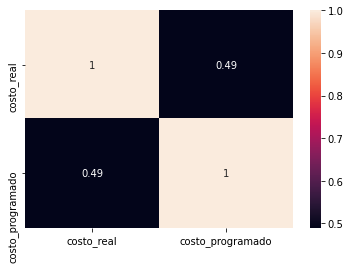

In [ ]:
# C) check correlation between variables 
corr_matrix = costo_marginal_clean[['costo_real','costo_programado']].corr()
sn.heatmap(corr_matrix, annot=True)

**Observación**: No hay una fuerte correlación entre el costo real y costo programado El costo que se programó no sigue la tendencia (lineal) del costo real. Esto es por ejemplo, cuando se programó que el costo iba a aumentar, el costo real no necesariamente aumentó.

[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b16485e10>


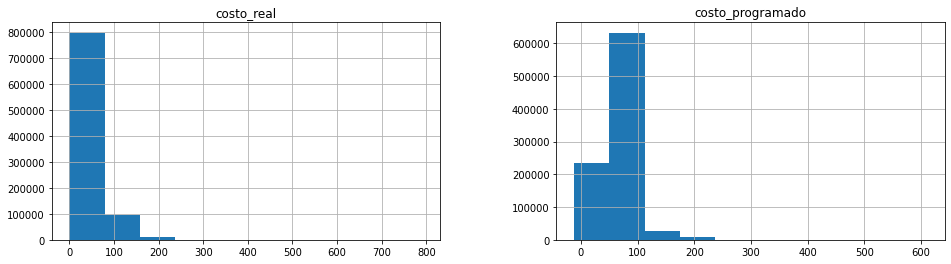

In [ ]:
# D) Check the data distribution
print(costo_marginal_clean[['costo_real','costo_programado']].hist(figsize=(16, 4)))

**Observación:** visualmente,*texto en cursiva* los costos reales se distribuyen mayormente entre ~0 y ~80 dólares, mientras que los costos que fueron programados se distribuyen mayormente entre ~50 y ~110 dólares

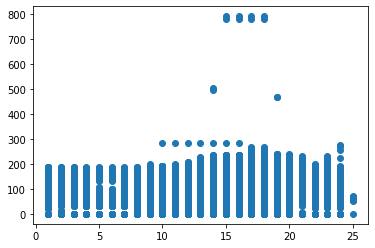

In [ ]:
# E) Check outliers 

# outliers en la variable costo real --> hora vs costo real
plt.scatter(costo_marginal_clean['hora'], costo_marginal_clean['costo_real'])
plt.show()

**Observación:** se puede ver muy pocos outliers, lo interesante es que estos siguen un patrón: por ejemplo los outliers en la parte de arriba se encuentran entre la hora de 15 a 20, con un costo de alrededor de $800

In [ ]:
# F) check missing values
costo_marginal_clean.isnull().sum()

Unnamed: 0                       0
barra_mnemotecnico               0
barra_referencia_mnemotecnico    0
fecha                            0
hora                             0
costo_real                       0
nombre                           0
costo_programado                 0
dtype: int64

**Observación:** No hay missing values

In [ ]:
# G) other

# Costo real por barra
costo_marginal_clean.groupby(costo_marginal_clean['barra_mnemotecnico'])['costo_real'].sum().sort_values() # group and sort

barra_mnemotecnico
BA01G049SE001G049         0.00
BA01T005SE284T005     87694.41
BA36T027SE067G216    109536.66
BA48T027SE123G216    112470.83
BA69T005SE281T005    113723.98
                       ...    
BA01T002SE031T002    381423.65
BA01T003SE001G041    383131.89
BA01T003SE032T003    385685.04
BA01T003SE005T003    398608.74
BA01T003SE015T003    406604.96
Name: costo_real, Length: 220, dtype: float64

**Observación:** Hay un total de 220 barras para las que se calcula el costo

In [ ]:
costo_marginal_clean.dtypes

Unnamed: 0                                int64
barra_mnemotecnico                       object
barra_referencia_mnemotecnico            object
fecha                            datetime64[ns]
hora                                      int64
costo_real                              float64
nombre                                   object
costo_programado                        float64
dtype: object

In [ ]:
# Costo real por mes
costo_marginal_clean['fecha'] = pd.to_datetime(costo_marginal_clean['fecha']) # 'fecha' as datetime data type
pd.DataFrame(costo_marginal_clean.groupby(costo_marginal_clean['fecha'].dt.strftime('%B'))['costo_real'].sum().sort_values()) # group and sort

,costo_real
fecha,
June,6105876.78
February,9044927.39
April,9269011.77
January,9363374.03
May,9403583.03
March,9573598.42


**Observaciones:** 
- El período de tiempo que abarca el banco de datos es de enero a junio de 2019
- El costo se mantiene estable en los primeros 5 meses del año, pero en junio este baja drásticamente

# **2. Construcción de variables**

**2.1. Feature engineering**

In [ ]:
# create variable 'desviación'
costo_marginal_clean['desviacion'] = np.sqrt((costo_marginal_clean['costo_real'] - costo_marginal_clean['costo_programado'])**2)

# create variable 'desviacion_pct'
costo_marginal_clean['desviacion_pct'] = (costo_marginal_clean['desviacion'] / costo_marginal_clean['costo_programado'])*100

# create variable 'desviacion_cat'
costo_marginal_clean['desviacion_cat'] = 0
costo_marginal_clean.desviacion_cat[costo_marginal_clean.desviacion_pct > 15] = 1

costo_marginal_clean.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,barra_mnemotecnico,barra_referencia_mnemotecnico,fecha,hora,costo_real,nombre,costo_programado,desviacion,desviacion_pct,desviacion_cat
527903,BA66T005SE285T005,BA02T002SE032T002,2019-01-01,14,46.47,BA S/E CALAMA 110KV - BP1,47.996887,1.526887,3.181221,0
261503,BA02T002SE037T002,BA02T002SE032T002,2019-01-01,7,42.30,BA S/E TEMUCO 220KV SECCIÓN 1,42.337972,0.037972,0.089688,0
642018,BA69T005SE281T005,BA02T002SE032T002,2019-01-01,17,0.00,BA S/E CERRO DRAGÓN 110KV,50.376058,50.376058,100.000000,1
642017,BA46G216SE021G216,BA02T002SE032T002,2019-01-01,17,0.00,BA S/E ANTOFAGASTA 110KV BP1,46.451488,46.451488,100.000000,1
642016,BA21L108SE013L135,BA02T002SE032T002,2019-01-01,17,0.00,BA S/E A 100KV-BP1,48.659112,48.659112,100.000000,1


**2.2. Description of variable: 'desviacion_cat'**

In [ ]:
#porcentaje que tiene desviacion mayor a 15% 
costo_marginal_clean['desviacion_cat'].value_counts()

0    666527
1    234402
Name: desviacion_cat, dtype: int64

In [ ]:
print('Porcentaje de los datos que tienen una desviación mayor al 15% :', round((234402/(666527+234402))*100,2),'% de los datos')

Porcentaje de los datos que tienen una desviación mayor al 15% : 26.02 % de los datos


**Observaciones:** Alrededor de la cuarta parte de las observaciones tienen una desviación mayor al 15%

In [ ]:
# Behavior over the time of variable 'desviacion_cat'
pd.DataFrame(costo_marginal_clean.groupby(costo_marginal_clean['fecha'].dt.strftime('%B'))['desviacion_cat'].sum().sort_values(ascending=False))

,desviacion_cat
fecha,
February,49374
April,47758
January,46894
March,42417
May,36596
June,11363


**Observaciones:** En los primeros meses del semestre, la cantidad de casos que se desvian más del 15% es estable, sin embargo, junio presenta una fuerte tendencia a la baja. Lo que quiere decir que la desviación es poca, y por lo tanto los costos programados empiezan acercarse más a los reales

In [ ]:
# Barras that have most of the cases with higher deviation
pd.DataFrame(costo_marginal_clean.groupby(costo_marginal_clean['nombre'])['desviacion_cat'].sum().sort_values(ascending=False))

,desviacion_cat
nombre,
BA S/E NUEVA VENTANAS JB1,4345
BA S/E CHOLGUAN 220KV,2810
BA S/E DIEGO DE ALMAGRO 110KV B1,1957
BA S/E MAITENCILLO 110KV SECCIÓN1,1821
BA S/E PUNITAQUI 66KV,1558
...,...
BA S/E RANCAGUA 66KV B1,701
BA S/E CANUTILLAR JBP-A,673
BA S/E DON GOYO 220KV BP2,633


**Observaciones:** 'NUEVA VENTANAS JB1' tiene una cantidad notablemente más alta de casos con desviación mayor al 15%. Al parecer, resulta más dificil hacer una programación precisa de los costos de esta barra.

# **3. Visualización de datos**

**3.1. Create the function: time_plot_costo_barra(codigo_barra, fecha_inicial, fecha_final)**

In [ ]:
# Create function time_plot_costo_barra(codigo_barra, fecha_inicial, fecha_final)

def time_plot_costo_barra(codigo_barra, fecha_inicial, fecha_final,data):

    # select according to barra
    groups = data.groupby('barra_mnemotecnico') # group data according to barras
    selected_group = groups.get_group(codigo_barra) # get the barra
    selected_group['fecha'] = pd.to_datetime(selected_group['fecha']) # set fecha as datetime data type
    selected_group = selected_group.sort_values(['fecha','hora'],ascending=True) # sort

    # select according to date
    selected_group_and_date = selected_group.groupby([selected_group['fecha'].dt.strftime('%Y'),selected_group['fecha'].dt.strftime('%m'),selected_group['fecha'].dt.strftime('%d')])['costo_programado','costo_real'].sum() # group according to date, specifically according to day
    selected_group_and_date.index = selected_group_and_date.index.set_names(['año','mes','dia']) # change i=names of multiindex
    selected_group_and_date.reset_index(inplace=True) # set multiindex as column in the dataframe
    selected_group_and_date['fecha'] = pd.to_datetime(dict(year=selected_group_and_date.año, month=selected_group_and_date.mes, day=selected_group_and_date.dia), format='%m/%d/%y') # create año, mes and día variables and set them as datetime data type
    selected_group_and_date = selected_group_and_date[(selected_group_and_date.fecha >= fecha_inicial) & (selected_group_and_date.fecha <= fecha_final)] # select cases between fecha_inicial and fecha_final
    selected_group_and_date.index = selected_group_and_date['fecha'] # set fecha as index

    # visualize
    color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"] # some design
    plt.style.use('fivethirtyeight')
    selected_group_and_date[['costo_programado', 'costo_real']].plot(figsize=(15, 5))

    return

**3.2. Give an example and describe**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if sys.path[0] == '':


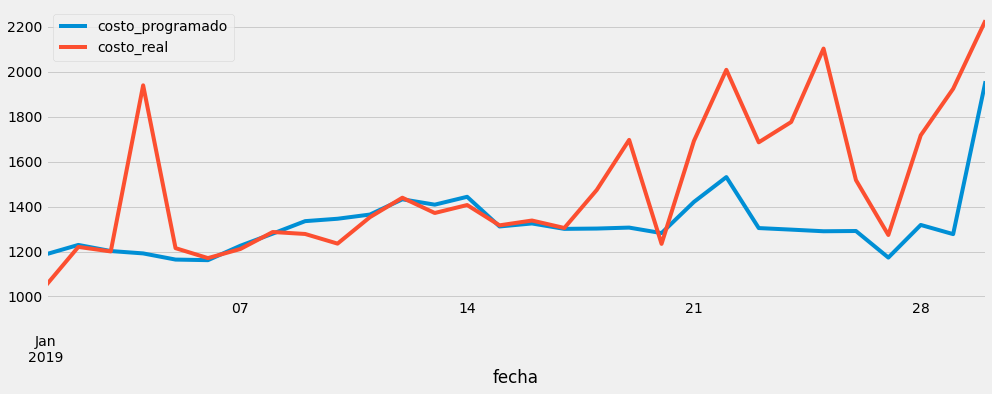

In [ ]:
# Give an example and describe
time_plot_costo_barra('BA01G004SE001T011','2019/01/01','2019/01/30',costo_marginal_clean)

**Observaciones:** no hay un patrón claro que se pueda distinguir. No se puede detectar seasonality porque no hay una cantidad de tiempo precisa entre los picos. Sin embargo, podría haber seasonality de acuerdo al mes del año, pero necesitaríamos datos de años anteriores para comparar y confirmar esto. Podría tener un patrón cíclico, ya que los datos suben y caen en períodos de tiempo no específicos, pero igualmente se necesitaría más datos para comprobar esto. 

# **4. Base para los modelos**

**4.1. Subir los datos**

In [ ]:
# Upload data

# invoke a file selector (select the files)
from google.colab import files

uploaded = files.upload()

# iterate the uploaded files in order to find their key names
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving base_para_prediccion.csv to base_para_prediccion.csv
User uploaded file "base_para_prediccion.csv" with length 10782529 bytes


In [ ]:
base_prediccion = pd.read_csv('base_para_prediccion.csv')
base_prediccion.head()

,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw
0,SE031G216,2019-01-04 00:00:00 UTC,1,NaN,NaN,NaN,NaN,0.0,56.2,55.627852,0.57,1.02,2,1210767,13.20785
1,SE031G216,2019-01-04 00:00:00 UTC,2,NaN,NaN,NaN,NaN,0.0,56.2,55.376645,0.82,1.48,2,113232,13.20785
2,SE031G216,2019-01-04 00:00:00 UTC,3,NaN,NaN,NaN,NaN,0.0,56.2,59.531891,-3.33,-5.59,2,1089415,13.20785
3,SE031G216,2019-01-04 00:00:00 UTC,4,NaN,NaN,NaN,NaN,0.0,56.2,174.378923,-118.18,-67.77,2,1096867,13.20785
4,SE031G216,2019-01-04 00:00:00 UTC,5,NaN,NaN,NaN,NaN,0.0,56.2,172.820310,-116.62,-67.48,2,1071851,13.20785


**4.2. Explorar los datos**

In [ ]:
# A) descriptive statistics
pd.DataFrame(base_prediccion.describe())

,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw
count,112779.000000,0.0,0.0,34184.000000,41818.000000,61863.000000,112779.000000,112779.000000,112779.000000,112779.00,112779.000000,1.127790e+05,112779.000000
mean,12.502993,NaN,NaN,38.120053,3.764987,40.583146,61.170058,62.215400,-1.045338,inf,2.331844,6.357056e+07,128.719565
std,6.924090,NaN,NaN,69.838109,12.904388,101.083396,25.414147,25.307759,24.711575,NaN,1.304096,3.948683e+08,167.948649
min,1.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,-1.713131,-562.470000,-3403.97,1.000000,-9.821095e+09,2.989800
25%,7.000000,NaN,NaN,0.849787,0.000000,0.000000,49.130000,49.906745,-3.790000,-7.07,1.000000,7.464800e+05,18.420000
50%,13.000000,NaN,NaN,9.600000,0.000000,0.000000,54.610000,55.420601,-0.310000,-0.58,2.000000,4.507282e+06,51.850000
75%,19.000000,NaN,NaN,40.000000,1.571022,15.960000,63.500000,64.701951,1.670000,2.92,3.000000,1.332345e+07,184.685500
max,25.000000,NaN,NaN,472.000000,86.050000,570.600800,240.360000,610.600000,175.020000,inf,6.000000,1.004240e+10,597.782800


In [ ]:
# B) Check missing values
base_prediccion.isnull().sum()

nemotecnico_se                   0
fecha                            0
hora                             0
gen_eolica_total_mwh        112779
gen_geotermica_total_mwh    112779
gen_hidraulica_total_mwh     78595
gen_solar_total_mwh          70961
gen_termica_total_mwh        50916
cmg_real                         0
cmg_prog                         0
cmg_desv                         0
cmg_desv_pct                     0
n_barras                         0
demanda_mwh                      0
cap_inst_mw                      0
dtype: int64

**Observaciones:**
- Todos los datos sobre la generación de energía eólica y energía geotérmica están perdidos
- Hay una cantidad considerable de missing values para la energía generada de forma hidráulica, solar y térmica, el 70%, 63% y 45% de los datos son missing values (respectivamente)

In [ ]:
# C) Count the number of cases that a type of energy generated zero mwh's
(base_prediccion == 0).sum()

nemotecnico_se                  0
fecha                           0
hora                            0
gen_eolica_total_mwh            0
gen_geotermica_total_mwh        0
gen_hidraulica_total_mwh     5586
gen_solar_total_mwh         22716
gen_termica_total_mwh       32104
cmg_real                     1212
cmg_prog                        1
cmg_desv                      168
cmg_desv_pct                  164
n_barras                        0
demanda_mwh                  8257
cap_inst_mw                     0
dtype: int64

**Observaciones:** los tipos de energía "solar" y "termica" tienen un alto número de casos donde generaron cero mwh's. Alrededor del 30% de los datos de la energía termica son cero, y alrededor del 20% de los datos de la energía solar son cero. 

**Otras observaciones interesantes:**
- Hay una variable categórica ('nemotecnico_se'), dos variables relacionadas al tiempo ('fecha' y 'hora'), una variable discreta ('n_barras') y el resto son variables continuas (11 variables). Lo que da una dimensionalidad de 15 variables
- El período de tiempo que abarca el banco de datos es de enero a junio de 2019

**4.3. Construcción de variables (feature engineering)**

In [ ]:
# Create variable año
base_prediccion['fecha'] = pd.to_datetime(base_prediccion['fecha']) # convret to datetime data type
base_prediccion = base_prediccion.sort_values(['nemotecnico_se','fecha','hora'],ascending=True) # sort
base_prediccion['año'] = pd.DatetimeIndex(base_prediccion['fecha']).year
# Create variable mes
base_prediccion['mes'] = pd.DatetimeIndex(base_prediccion['fecha']).month
# Create variable semana
base_prediccion['semana'] = pd.DatetimeIndex(base_prediccion['fecha']).week
# Create variable día
base_prediccion['day'] = pd.DatetimeIndex(base_prediccion['fecha']).day # números de 0 a 6
# Create variable dia de la semana
base_prediccion['dia_semana'] = pd.DatetimeIndex(base_prediccion['fecha']).dayofweek
# Create variable that indicates whether it is weekday or weekend
base_prediccion['semana_findesemana'] = ((pd.DatetimeIndex(base_prediccion['fecha']).dayofweek) // 5 == 1).astype(float) # 0 if weekday, 1 if weekend

base_prediccion.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw,año,mes,semana,day,dia_semana,semana_findesemana
120,SE001T002,2019-01-01 00:00:00+00:00,1,NaN,NaN,NaN,0.0,0.0,54.03,124.604410,-70.57,-56.64,2,61148556,14.2881,2019,1,1,1,1,0.0
121,SE001T002,2019-01-01 00:00:00+00:00,2,NaN,NaN,NaN,0.0,0.0,54.03,125.415516,-71.39,-56.92,2,136880002,14.2881,2019,1,1,1,1,0.0
122,SE001T002,2019-01-01 00:00:00+00:00,3,NaN,NaN,NaN,0.0,0.0,54.03,52.383209,1.65,3.15,2,127833826,14.2881,2019,1,1,1,1,0.0
123,SE001T002,2019-01-01 00:00:00+00:00,4,NaN,NaN,NaN,0.0,0.0,54.03,53.482023,0.55,1.03,2,133924965,14.2881,2019,1,1,1,1,0.0
124,SE001T002,2019-01-01 00:00:00+00:00,5,NaN,NaN,NaN,0.0,0.0,54.03,52.260469,1.77,3.39,2,138980453,14.2881,2019,1,1,1,1,0.0


**4.4. Función que para una subestación y una variable, grafique múltiples series de tiempo diarias correspondientes a una lista de fechas**

In [ ]:
def produccion_energia_diaria_subestacion(codigo_subestacion,var_tipo_de_energia,lista_fechas,data):

    data['fecha'] = pd.to_datetime(data['fecha'])  # set fechas as datetime data type

    for fecha in lista_fechas:

        # select according to subestacion and date
        selected_subestacion_fecha = data[(data['nemotecnico_se'] == codigo_subestacion) & (data['fecha'] == fecha)]
        selected_subestacion_fecha.index = selected_subestacion_fecha['hora']

        # visualize
        color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"] # some design
        plt.style.use('fivethirtyeight')
        plt.plot(selected_subestacion_fecha['hora'],selected_subestacion_fecha[var_tipo_de_energia],label=fecha)
        plt.show()

    return


**4.5. Compare subestación SE005T002 vs SE127T005**

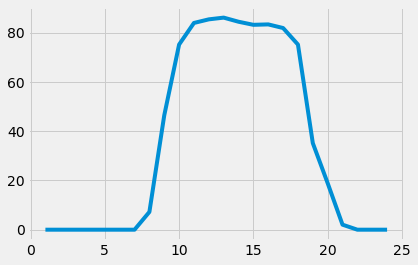

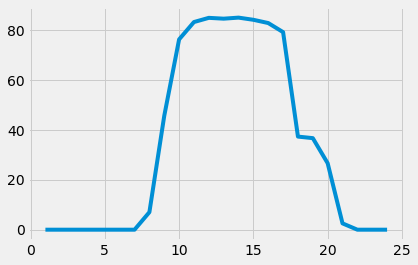

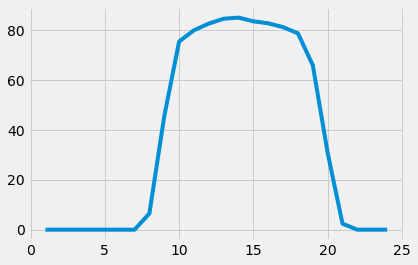

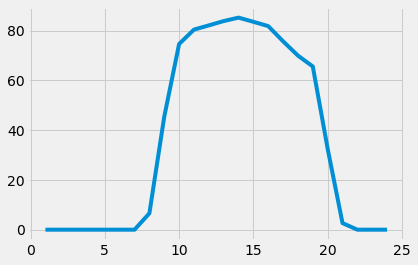

In [ ]:
# Subestacion SE005T002
produccion_energia_diaria_subestacion('SE005T002','gen_solar_total_mwh',['2019/01/11','2019/01/12','2019/01/13','2019/01/14'],base_prediccion)

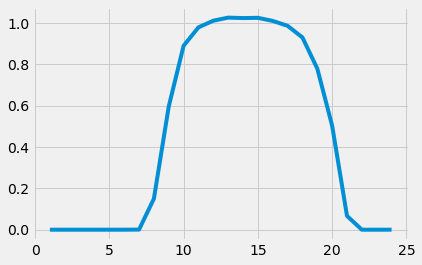

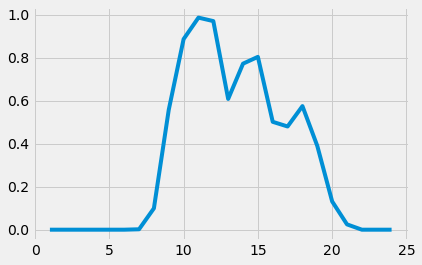

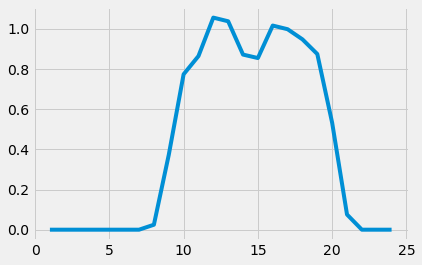

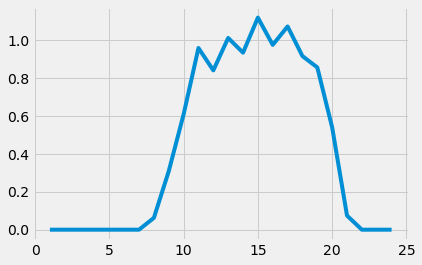

In [ ]:
produccion_energia_diaria_subestacion('SE127T005','gen_solar_total_mwh',['2019/01/11','2019/01/12','2019/01/13','2019/01/14'],base_prediccion)

**Observaciones:**
-La generación de energía solar empieza en la mañana, alcanza su pico en la tarde y a la entrada de la noche ya no se genera energía
-El patron que se forma es similar para todos los días (lo cual se puede esperar si el clima es simlar en días seguidos)
-La subestación SE005T002 genera mucha más energía solar que la subestación SE127T005, con un máximo de ~80 mwh para la subestación SE005T002 y un máximo de ~1.1 mwh para la subestación SE127T005

**4.6. Comparar subestación SE020G213 vs. SE106G216**

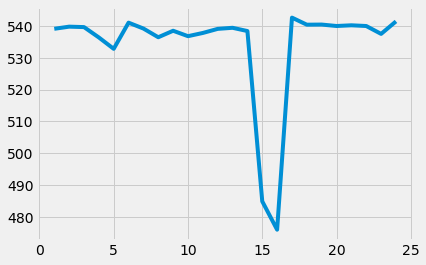

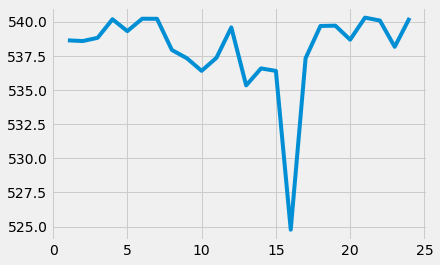

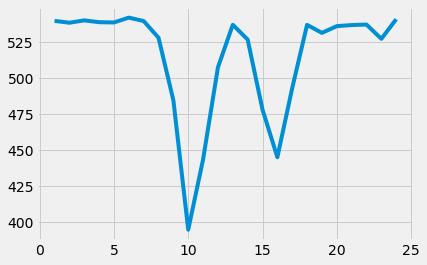

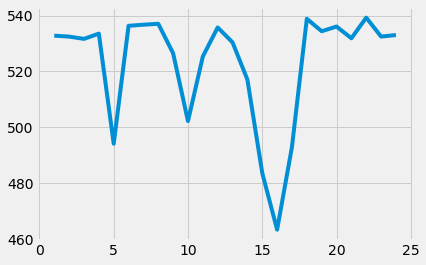

In [ ]:
# Subestación SE020G213
produccion_energia_diaria_subestacion('SE020G213','gen_termica_total_mwh',['2019/05/14','2019/05/15','2019/05/16','2019/05/17'],base_prediccion)

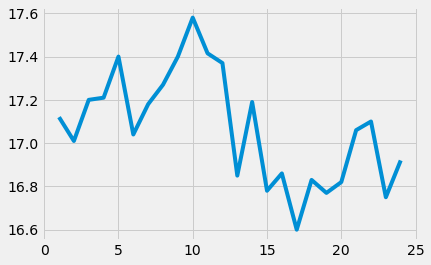

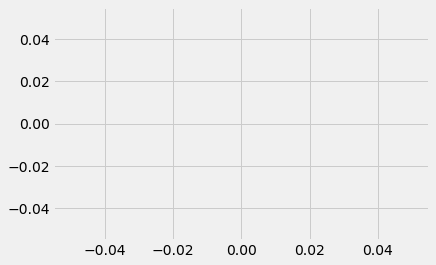

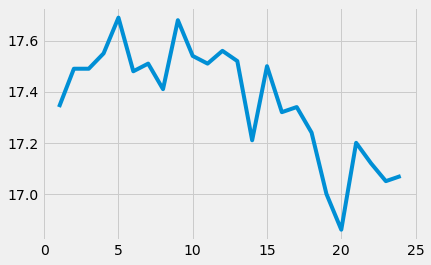

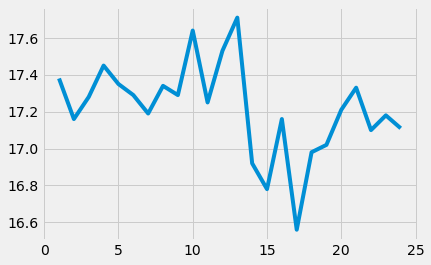

In [ ]:
# Subestación SE106G216
produccion_energia_diaria_subestacion('SE106G216','gen_termica_total_mwh',['2019/05/14','2019/01/15','2019/05/16','2019/05/17'],base_prediccion)

**Observaciones:**
-A diferencia de la energía solar, la generación de energía térmica es independiente de la hora del día, por lo que presenta un patrón más estable a lo largo del día
-El patron que se forma es similar para todos los días (lo cual se puede esperar si las condiciones son simlares en días seguidos)
-La subestación SE020G213 genera mucha más energía solar que la subestación SE106G216, con un máximo de ~540 mwh para la subestación SE020G213 y un máximo de ~17.6 mwh para la subestación SE106G216

# **5. Predicción de desviaciones del costo marginal: modelo 1**

**Notas:** 
- El modelo que se usa es **"extreme gradient boosted decision trees"** por medio de la librería XGBoost
- La variable de predicción es cmg_desv_cat. Lo que hace de este un **caso de clasificación**, en donde 0 corresponde a "desviación es menor al 15%" y "1 desviación mayor al 15%"
- Para **evitar data leakage**, las variables con las que se contruyó la variable target (cmg_desv_cat) son descartadas del modelo (variables descartadas: 'cmg_real', 'cmg_prog', y 'cmg_desv')


**5.1. Feature engineering**


In [ ]:
# A) Create variable that identifies if the deviation is greater than 15%
base_prediccion['cmg_desv_pct'] = np.sqrt(base_prediccion['cmg_desv_pct']**2)
base_prediccion['cmg_desv_cat'] = 0 # create variable
base_prediccion.cmg_desv_cat[base_prediccion.cmg_desv_pct > 15] = 1 # 1 if it is grester than 15%

# B) Create feature: total energy generation (sum of the types of energy)
# check if there are cases where all types of energy are nan's
len(base_prediccion[(base_prediccion['gen_hidraulica_total_mwh'] == np.nan) & (base_prediccion['gen_solar_total_mwh'] == np.nan) & (base_prediccion['gen_termica_total_mwh'] == np.nan)]) 
# sum up (for summing up, we'll consider nan's as zero)
base_prediccion['en_total_mwh'] = base_prediccion['gen_hidraulica_total_mwh'].fillna(0) + base_prediccion['gen_solar_total_mwh'].fillna(0) + base_prediccion['gen_termica_total_mwh'].fillna(0) 

# C) Lag: add as a feature the desv_cat of the day before
lag_desv_cat_del_dia_anterior = base_prediccion.iloc[24:,:]
lag_desv_cat_del_dia_anterior = lag_desv_cat_del_dia_anterior.reset_index(drop=True)
lag_desv_cat_del_dia_anterior = lag_desv_cat_del_dia_anterior['cmg_desv_cat'] # el método para añadir el lag no es preciso 100% pero se acerca bastante a la idea
base_prediccion = base_prediccion.iloc[:-24,:]
base_prediccion = base_prediccion.reset_index(drop=True)
base_prediccion['lag_desv_cat_del_dia_anterior'] = lag_desv_cat_del_dia_anterior

# D) Set the names of the subestaciones (nemotecnico_se) as numbers
base_prediccion['nemotecnico_se2'] = base_prediccion['nemotecnico_se'].astype('category') # set as category data type
base_prediccion['nemotecnico_se2'] = base_prediccion['nemotecnico_se2'].cat.codes # from categories to numbers

base_prediccion.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw,año,mes,semana,day,dia_semana,semana_findesemana,cmg_desv_cat,en_total_mwh,lag_desv_cat_del_dia_anterior,nemotecnico_se2
0,SE001T002,2019-01-01 00:00:00+00:00,1,NaN,NaN,NaN,0.0,0.0,54.03,124.604410,-70.57,56.64,2,61148556,14.2881,2019,1,1,1,1,0.0,1,0.0,0,0
1,SE001T002,2019-01-01 00:00:00+00:00,2,NaN,NaN,NaN,0.0,0.0,54.03,125.415516,-71.39,56.92,2,136880002,14.2881,2019,1,1,1,1,0.0,1,0.0,0,0
2,SE001T002,2019-01-01 00:00:00+00:00,3,NaN,NaN,NaN,0.0,0.0,54.03,52.383209,1.65,3.15,2,127833826,14.2881,2019,1,1,1,1,0.0,0,0.0,0,0
3,SE001T002,2019-01-01 00:00:00+00:00,4,NaN,NaN,NaN,0.0,0.0,54.03,53.482023,0.55,1.03,2,133924965,14.2881,2019,1,1,1,1,0.0,0,0.0,1,0
4,SE001T002,2019-01-01 00:00:00+00:00,5,NaN,NaN,NaN,0.0,0.0,54.03,52.260469,1.77,3.39,2,138980453,14.2881,2019,1,1,1,1,0.0,0,0.0,1,0


**Nota:** no se consideró la creación de otras variables con estadísticas acumuladas (a partir del tipo de energías) porque hay una gran cantidad de missing values, que al no saber los motivos de porqué están perdidos, podrían perturbar lo ocurrido en la vida real y por lo tanto al modelo. 

**5.3. Entrena un modelo que prediga si existirá una desviación en la hora siguiente**

In [ ]:
# A) Split train and test data
msk = np.random.rand(len(base_prediccion)) < 0.8
data_train = base_prediccion[msk]
data_test = base_prediccion[~msk]

# B) Identify independent variables
X_train = data_train[['nemotecnico_se2','hora','gen_hidraulica_total_mwh','gen_solar_total_mwh','gen_termica_total_mwh',
                      'n_barras','demanda_mwh','cap_inst_mw','año','mes','semana','day','dia_semana',
                      'semana_findesemana','en_total_mwh','lag_desv_cat_del_dia_anterior']]

X_test = data_test[['nemotecnico_se2','hora','gen_hidraulica_total_mwh','gen_solar_total_mwh','gen_termica_total_mwh',
                    'n_barras','demanda_mwh','cap_inst_mw','año','mes','semana','day','dia_semana',
                    'semana_findesemana','en_total_mwh','lag_desv_cat_del_dia_anterior']]

# C) Identify the dependent variable (labels)
y_train = data_train['cmg_desv_cat']
y_test = data_test['cmg_desv_cat']

# D) Build XGBoost model and train it
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=True)

[09:37:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.483676	validation_1-rmse:0.48354
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:0.470016	validation_1-rmse:0.469777
[2]	validation_0-rmse:0.458522	validation_1-rmse:0.458176
[3]	validation_0-rmse:0.448952	validation_1-rmse:0.448583
[4]	validation_0-rmse:0.441018	validation_1-rmse:0.440581
[5]	validation_0-rmse:0.434441	validation_1-rmse:0.433912
[6]	validation_0-rmse:0.428939	validation_1-rmse:0.428374
[7]	validation_0-rmse:0.42433	validation_1-rmse:0.423775
[8]	validation_0-rmse:0.420539	validation_1-rmse:0.419981
[9]	validation_0-rmse:0.417252	validation_1-rmse:0.416745
[10]	validation_0-rmse:0.41454	validation_1-rmse:0.414102
[11]	validation_0-rmse:0.412279	validation_1-rmse:0.411798
[12]	validation_0-r

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
# E) Model evaluation

# Get prediction on validation set
y_pred = reg.predict(X_test)

# Confusion matrix
cm = confusion_matrix((y_pred > 0.5), y_test)
cm

array([[16032,  3387],
       [  767,  2327]])

In [ ]:
# Calculate the accuracy on test2 set
predict_accuracy_on_test_set = (cm[0, 0] + cm[1, 1]) / (cm[0, 0] + cm[1, 1] + cm[1, 0] + cm[0, 1])
print('The Accuracy on Test Set is: ', predict_accuracy_on_test_set)

The Accuracy on Test Set is:  0.8154843867987385


In [ ]:
# calculate Precision
precision = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print('The Precision on Test Set is: ', precision)

The Precision on Test Set is:  0.7521008403361344


In [ ]:
# Calculate Recall
recall = cm[1, 1] / (cm[1, 1] + cm[0, 1])
print('The Recall on Test Set is: ', recall)

The Recall on Test Set is:  0.4072453622681134


**Nota**: La evaluación del modelo se realiza con las métricas **Precision** and **Recall**, que son métricas populares, simples de implementar y comprender para casos de clasificación. Además se usa la métrica general de precisión **(general accuracy)** que nos dice simplemente el porcentaje de clasificaciones correctas.

**Conclusiones:**
- Precisión: 75% -> de las observaciones clasificadas como "desviación mayor al 15%", el 75% fueron correctamente clasificadas
- Recall: 41% -> del total de observaciones en la clase "desviación mayor al 15%", tan solo el 41% fueron clasificadas correctamente. En parte, puede deberse al imbalance que hay en la data, ya que hay ~3 veces más observaciones en la clase "desviacion menor al 15%" en en la clase "desviación mayor al 15%", por lo que el modelo no puede aprender lo suficiente sobre esta clase. Algunas ideas para solucionar el problema: 1) implementar técnicas de sampling para balancear la data, 2) buscar otras variables que produzcan los patrones que representan mejor a esta clase. 
- En general, la accuracy del modelo puede considerarse "buena" (82%)

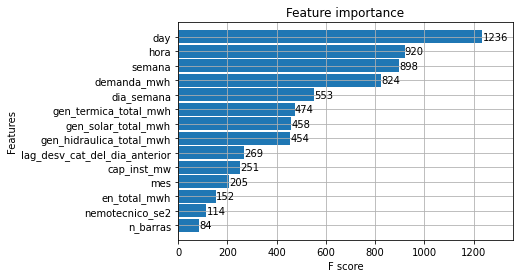

In [ ]:
# F) Plot feature importance
plot_importance(reg, height=0.9)

**Observaciones:** 
- Las variables "día", "hora","semana", y "demanda_mwh" son las principales variables que influencian las decisines que el modelo toma.
- Nota que la variable incluida como lag (que incluye la desviación_cat del día anterior) contribuye medianamente, sin embargo, la variable incluida que suma el total generado por todos los tipos de energía (en_total_mwh) aporta muy poco en la toma de decisiones, lo que puede ser una señal para excluir la variable del modelo.

# **6. Predicción de desviaciones del costo marginal: modelo 2**

**Nota:** Suponiendo que nos envian los **datos actualizados del sistema** **cada 12 horas**, y que nuestro modelo es entrenado continuamente, entonces no tendríamos a disposición los costos reales, por lo que no podríamos  hacer el cómputo de la desviación. Sin embargo, los datos todavía pueden ser útiles para hacer el pronóstico de los costos. **El siguiente modelo toma entonces como variable target cmg_progr**, el cuál **ya no es un caso de clasificación** como en el modelo anterior, pero de regresión.

In [ ]:
# A) Data
base_prediccion_modelo2 = base_prediccion.copy()
# Check whether there are real costs equal to zero
len(base_prediccion_modelo2.loc[base_prediccion_modelo2['cmg_real'] == 0]) #
# Drop observations where cost real equal to zero 
base_prediccion_modelo2 = base_prediccion_modelo2[base_prediccion_modelo2['cmg_real'] != 0]

# B) split train and test data
msk = np.random.rand(len(base_prediccion_modelo2)) < 0.8
data_train_modelo2 = base_prediccion_modelo2[msk]
data_test_modelo2 = base_prediccion_modelo2[~msk]

# C) Identify independent variables
X_train2 = data_train_modelo2[['nemotecnico_se2','hora','gen_hidraulica_total_mwh','gen_solar_total_mwh','gen_termica_total_mwh',
                      'n_barras','demanda_mwh','cap_inst_mw','año','mes','semana','day','dia_semana',
                      'semana_findesemana','en_total_mwh','lag_desv_cat_del_dia_anterior']]
X_test2 = data_test_modelo2[['nemotecnico_se2','hora','gen_hidraulica_total_mwh','gen_solar_total_mwh','gen_termica_total_mwh',
                    'n_barras','demanda_mwh','cap_inst_mw','año','mes','semana','day','dia_semana',
                    'semana_findesemana','en_total_mwh','lag_desv_cat_del_dia_anterior']]

# D) Identify the dependent variable (labels)
y_train2 = data_train_modelo2['cmg_real']
y_test2 = data_test_modelo2['cmg_real']

# E) Build XGBoost model and train it
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train2, y_train2,
        eval_set=[(X_train2, y_train2), (X_test2, y_test2)],
        early_stopping_rounds=50,
        verbose=True)

[10:01:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:60.3075	validation_1-rmse:60.3428
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:55.1419	validation_1-rmse:55.1882
[2]	validation_0-rmse:50.5623	validation_1-rmse:50.6276
[3]	validation_0-rmse:46.511	validation_1-rmse:46.5919
[4]	validation_0-rmse:42.964	validation_1-rmse:43.0585
[5]	validation_0-rmse:39.7913	validation_1-rmse:39.8998
[6]	validation_0-rmse:37.06	validation_1-rmse:37.1826
[7]	validation_0-rmse:34.662	validation_1-rmse:34.8089
[8]	validation_0-rmse:32.5486	validation_1-rmse:32.7055
[9]	validation_0-rmse:30.754	validation_1-rmse:30.9203
[10]	validation_0-rmse:29.194	validation_1-rmse:29.3732
[11]	validation_0-rmse:27.8665	validation_1-rmse:28.0658
[12]	validation_0-rmse:26.725	validation_1-rmse

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
# F) Model evaluation

# Prediction on validation set
y_pred2 = reg.predict(X_test2)

# Mean squared error
mean_sq_error = mean_squared_error(y_true = y_test2, y_pred = y_pred2)

# Mean absolute error
mean_abs_error = mean_absolute_error(y_true = y_test2, y_pred = y_pred2)

# Mean absolute percent error
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_abs_percentage_error = mean_absolute_percentage_error(y_true = y_test2, y_pred = y_pred2)

# Create a data frame with the results fo all metrics
results = {'Evaluation method': ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'],
           'Result': [mean_sq_error, mean_abs_error, mean_abs_percentage_error],}
pd.DataFrame(results, columns=['Evaluation method', 'Result'])

,Evaluation method,Result
0,mean_squared_error,196.543373
1,mean_absolute_error,8.815772
2,mean_absolute_percentage_error,15.532276


**Nota:** Las métricas que se utilizan en este caso son: "mean squared error", "mean absolute error" y "mean absolute percentage error", las cuales son populares y fáciles de comprender para casos de regresión (variable continua) 

**Conclusiones:**
- Mean absolute error: 8.82 -> en promedio, el error absoluto se desvía $8.82 del costo pronosticado.
- Mean absolute percentage error: 15.53% -> en promedio, el modelo se desvía un 15.53% del costo pronosticado.


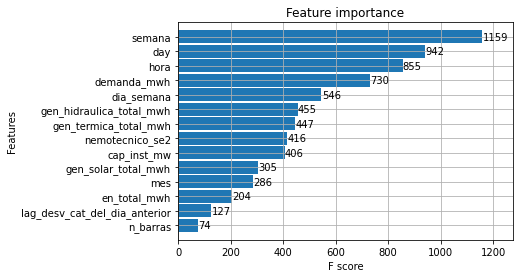

In [ ]:
# Plot feature importance
plot_importance(reg, height=0.9)

**Observaciones:** Las variables que más influyen en las decisiones que el modelo toma son: "semana", "dia", "hora", y "demanda mwh". Por otro lado, la variable que menos influencia tiene es el número de barras (n_barras). 

**Nota** que las variables construidas (feature engineering) con el total de energía generada y el lag, tampoco influyen mucho en la toma de desiciones

# **7. Merge con datos de clima: modelo 3**

In [ ]:
# A) Prepare data

# Base for prediction data
base_prediccion_modelo3 = base_prediccion_modelo2
base_prediccion_modelo3['fecha'] = pd.to_datetime(base_prediccion_modelo3['fecha']) # convert to datetime data type

# Upload clima data
# invoke a file selector (select the files)
from google.colab import files

uploaded = files.upload()

# iterate the uploaded files in order to find their key names
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving datos_clima.csv to datos_clima.csv
User uploaded file "datos_clima.csv" with length 791413 bytes


In [ ]:
clima = pd.read_csv('datos_clima.csv') # read data 
clima['fecha'] = pd.to_datetime(clima['fecha']) # change to datetime type
clima = clima.sort_values(['fecha','subestacion'],ascending = [True,True]) # sort 
clima.rename(columns={'subestacion':'nemotecnico_se'}, inplace=True)  # rename variables (for later merging)

# Merge base_prediccion and clima data
base_prediccion_modelo3 = pd.merge(base_prediccion_modelo3,clima,on=['fecha','nemotecnico_se'])
base_prediccion_modelo3.head()

,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw,año,mes,semana,day,dia_semana,semana_findesemana,cmg_desv_cat,en_total_mwh,lag_desv_cat_del_dia_anterior,nemotecnico_se2,lat,lon,ALLSKY_SFC_SW_DWN,KT,PRECTOT,RH2M,T2M,T2MDEW,T2M_MAX,T2M_MIN,TQV,TS,WS10M,WS10M_MAX,WS10M_MIN,WS50M,WS50M_MAX,WS50M_MIN
0,SE001T002,2019-01-01 00:00:00+00:00,1,NaN,NaN,NaN,0.0,0.0,54.03,124.604410,-70.57,56.64,2,61148556,14.2881,2019,1,1,1,1,0.0,1,0.0,0,0,-27.487872,-70.38801,8.86,0.73,0.0,37.11,21.08,5.78,27.92,15.05,1.24,25.32,3.02,6.34,0.18,2.82,5.46,0.21
1,SE001T002,2019-01-01 00:00:00+00:00,2,NaN,NaN,NaN,0.0,0.0,54.03,125.415516,-71.39,56.92,2,136880002,14.2881,2019,1,1,1,1,0.0,1,0.0,0,0,-27.487872,-70.38801,8.86,0.73,0.0,37.11,21.08,5.78,27.92,15.05,1.24,25.32,3.02,6.34,0.18,2.82,5.46,0.21
2,SE001T002,2019-01-01 00:00:00+00:00,3,NaN,NaN,NaN,0.0,0.0,54.03,52.383209,1.65,3.15,2,127833826,14.2881,2019,1,1,1,1,0.0,0,0.0,0,0,-27.487872,-70.38801,8.86,0.73,0.0,37.11,21.08,5.78,27.92,15.05,1.24,25.32,3.02,6.34,0.18,2.82,5.46,0.21
3,SE001T002,2019-01-01 00:00:00+00:00,4,NaN,NaN,NaN,0.0,0.0,54.03,53.482023,0.55,1.03,2,133924965,14.2881,2019,1,1,1,1,0.0,0,0.0,1,0,-27.487872,-70.38801,8.86,0.73,0.0,37.11,21.08,5.78,27.92,15.05,1.24,25.32,3.02,6.34,0.18,2.82,5.46,0.21
4,SE001T002,2019-01-01 00:00:00+00:00,5,NaN,NaN,NaN,0.0,0.0,54.03,52.260469,1.77,3.39,2,138980453,14.2881,2019,1,1,1,1,0.0,0,0.0,1,0,-27.487872,-70.38801,8.86,0.73,0.0,37.11,21.08,5.78,27.92,15.05,1.24,25.32,3.02,6.34,0.18,2.82,5.46,0.21


In [ ]:
# Built and train the model

# B) split train and test data
msk = np.random.rand(len(base_prediccion_modelo3)) < 0.8
data_train_modelo3 = base_prediccion_modelo3[msk]
data_test_modelo3 = base_prediccion_modelo3[~msk]

# C) Identify independent variables 
X_train3 = data_train_modelo3[['nemotecnico_se2','hora','gen_hidraulica_total_mwh','gen_solar_total_mwh','gen_termica_total_mwh',
                                'n_barras','demanda_mwh','cap_inst_mw','año','mes','semana','day','dia_semana',
                                'semana_findesemana','en_total_mwh','lag_desv_cat_del_dia_anterior','lat','lon','ALLSKY_SFC_SW_DWN',
                                'KT','PRECTOT','RH2M','T2M','T2MDEW','T2M_MAX','T2M_MIN','TQV','TS','WS10M','WS10M_MAX','WS10M_MIN',
                                'WS50M','WS50M_MAX','WS50M_MIN']]

X_test3 = data_test_modelo3[['nemotecnico_se2','hora','gen_hidraulica_total_mwh','gen_solar_total_mwh','gen_termica_total_mwh',
                                'n_barras','demanda_mwh','cap_inst_mw','año','mes','semana','day','dia_semana',
                                'semana_findesemana','en_total_mwh','lag_desv_cat_del_dia_anterior','lat','lon','ALLSKY_SFC_SW_DWN',
                                'KT','PRECTOT','RH2M','T2M','T2MDEW','T2M_MAX','T2M_MIN','TQV','TS','WS10M','WS10M_MAX','WS10M_MIN',
                                'WS50M','WS50M_MAX','WS50M_MIN']]

# C) Identify the dependent variable
y_train3 = data_train_modelo3['cmg_real']
y_test3 = data_test_modelo3['cmg_real']

# D) Build XGBoost model and train it
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train3, y_train3,
        eval_set=[(X_train3, y_train3), (X_test3, y_test3)],
        early_stopping_rounds=50,
        verbose=True)

[19:31:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:60.2047	validation_1-rmse:60.1965
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:54.9288	validation_1-rmse:54.9167
[2]	validation_0-rmse:50.241	validation_1-rmse:50.2349
[3]	validation_0-rmse:46.0915	validation_1-rmse:46.0802
[4]	validation_0-rmse:42.4259	validation_1-rmse:42.4265
[5]	validation_0-rmse:39.1887	validation_1-rmse:39.1986
[6]	validation_0-rmse:36.3429	validation_1-rmse:36.349
[7]	validation_0-rmse:33.8376	validation_1-rmse:33.8438
[8]	validation_0-rmse:31.6615	validation_1-rmse:31.6604
[9]	validation_0-rmse:29.7463	validation_1-rmse:29.7516
[10]	validation_0-rmse:28.089	validation_1-rmse:28.1038
[11]	validation_0-rmse:26.6474	validation_1-rmse:26.6646
[12]	validation_0-rmse:25.4164	validation_1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
# E) Model validation

# Get prediction on validation set
y_pred3 = reg.predict(X_test3)

# Mean squared error
mean_sq_error3 = mean_squared_error(y_true = y_test3, y_pred = y_pred3)

# Mean absolute error
mean_abs_error3 = mean_absolute_error(y_true = y_test3, y_pred = y_pred3)

# Mean absolute percent error
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_abs_percentage_error3 = mean_absolute_percentage_error(y_true = y_test3, y_pred = y_pred3)

# Create a data frame with the results fo all metrics
results3 = {'Evaluation method': ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'],
           'Result': [mean_sq_error3, mean_abs_error3, mean_abs_percentage_error3],}
pd.DataFrame(results3, columns=['Evaluation method', 'Result'])




,Evaluation method,Result
0,mean_squared_error,159.995884
1,mean_absolute_error,7.884068
2,mean_absolute_percentage_error,13.735359


**Observaciones:** Con la inclusión de variables relacionadas al clima, los resultados que se obtienen son mejores en comparación con el modelo anterior. Porcentualmente, el error decreció (en promedio) en un 1.79% (de 15.53% a 13.74%). Mientras que el mean absolute error pasó de 8.82 a $7.88

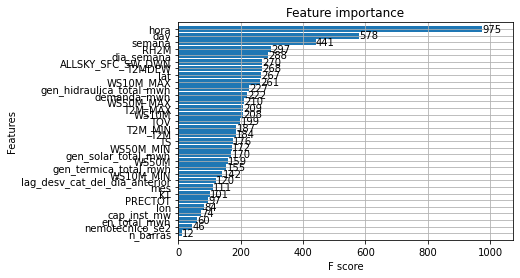

In [ ]:
# Plot feature importance
plot_importance(reg, height=0.9)

**Observaciones:** Las variables día y hora son las que más influencian en las decisiones que toma el modelo, lo cuál es similar al modelo anterior. **Nota interesante:** varias variables relacionadas al clima que se incluyeron también influencian en las decisiones, por lo que puede considerarse que su inclusión sí contribuye en la cosntrucción del modelo.

# **8. Reflexión**


**¿Por qué sería bueno utilizar un modelo como este para anticiparse a desvíos de precios de la energía?**

Ya que el precio es determinado por el costo, es importante hacer un monitoreo apropiado de este. Al ser el costo una medida tan volátil en el negocio, un buen modelo de pronóstico puede ayudar por ejemplo a crear cierto ambiente de certidumbre, a anticiparnos a posibles escenarios adversos, y principalmente en la toma de decisiones basada en ciencia.

**¿Qué casos de uso te imaginas podrían beneficiarse teniendo acceso a un modelo como este?**

En relación a las variables usadas:
- Casos en los que datos relacionados al clima afectan al tipo de negocio.

En relación a la técnica usada:
- Casos de time series: ya que es conocido que XGboost tiene un buen desempeño en estos escenarios. 
- Casos que manejan grandes volúmenes de datos: ya que XGboost puede trabajar eficientemente con casos a larga escala. Es comprobado que este es más rápido que otras técnicas debido a su memory efficiency y debido a que, con las herramientas adecuadas, permite parallel computing.
- Casos en donde no haya una relación lineal entre las variables independientes y la variable target: ya que los árboles de decisión son buenos en detectar relaciones no lineales.

En relación al tipo de negocio:
- Negocios en los que el costo (o variables similares) varía tanto que este puede diferir notablemente de un día al otro o incluso de una hora a la otra (considerable nivel de incertidumbre). 